# PBFE Framework

Authors: Fan Hu, Selim Gunay

Summer 2021

**Import Modules**

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
from scipy.stats import lognorm
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale = 1.0)
rc={'figure.figsize':(12,8)}
plt.rc('figure', dpi=100, figsize=(7, 5))
plt.rc('font', size=12)
rng = np.random.default_rng()

## Agricutural Facility

UC Davis Agrivoltaic farm for growing tomatoes

PBFE will eventually be applied to compute the median lifecycle costs for the following options 
- Option 1) Regular operations
- Option 2) Adopt an agrivoltaic system
- Option 3) Use energy efficient irrigations systems
- Option 4) Deficit irrigation management (Less irrigation during vegetation phase)

This file is for demonstration purposes, therefore it does not completely represent any of the four options. 

## Environmental Hazard Analysis

Generate the probability values in Phase 1 (Environmental hazard analysis)

**Hazard**: Drought, **IM**: Drought Category 

Five Intensity values: __D0__ (Abnormally Dry), __D1__ (Moderate Drought), __D2__ (Severe Drought), __D3__ (Extreme Drought), __D4__ (Exceptional Drought)

In [2]:
# Assume p_IM(D1) = 1.0, p_IM(Others) = 0
p_IM = np.zeros(5)
p_IM[1] = 1.0 
p_IM

array([0., 1., 0., 0., 0.])

## Crop Growth Analysis

Generate the probability values in Phase 2 (Crop growth analysis)

**SM**: Leaf Area Index (LAI) 

**LAI**: One-sided green leaf area per unit ground surface area. LAI reduces as drought increases because the leaf area reduces with increased temperature and reduced precipitation. 

Probability distribution of LAI needs to be generated for each IM value. 

The PDF for `lognormal` is: $$f(x,s) = \frac{1}{sx\sqrt{2\pi}}exp(-\frac{log^2(x)}{2s^2})$$
for $x>0, s>0$. `lognorm.pdf(x, s, loc, scale)` is identically equivalent to `lognorm.pdf(y, s) / scale` with `y = (x - loc) / scale`.

If $log(x)$ is normally distributed with mean $\mu$ and variance $\sigma^2$, then $x$ is log-normally distributed with shape parameter $\sigma$ and scale parameter $e^\mu$.

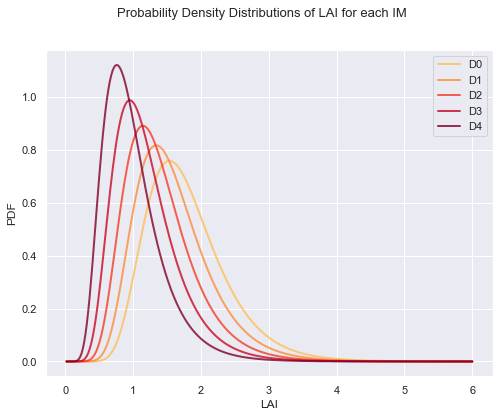

In [3]:
# Develop the probability distributions of LAI for each IM

dr_levels = np.arange(5) + 1

mean_SM = 2 - dr_levels * 0.2   # mean_LAI is assumed to decrease linearly with the drought
cov_SM = 0.2                    # cov_LAI is assumed to be the same for all levels
                                # Actual mean and COV values to be found from literature or AI on Omar's pictures
var_SM = mean_SM * cov_SM
incr_SM = 0.02
max_SM = 6

# Find the parameters to be used with the lognorm function 
mu_SM = np.log(mean_SM ** 2 / np.sqrt(var_SM + mean_SM ** 2))
sd_SM = np.sqrt(np.log(1 + var_SM / mean_SM ** 2) )

# Plot the PDF
vals_SM = np.linspace(incr_SM, max_SM, num = 300)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
fig.suptitle('Probability Density Distributions of LAI for each IM', fontsize=13)
colors = pl.cm.YlOrRd(np.linspace(0,1,7))

p_SM = np.zeros([len(dr_levels), len(vals_SM)])
sumprob_SM = np.zeros(len(dr_levels))

for i in np.arange(len(dr_levels)):
    rv = lognorm(sd_SM[i], scale=np.exp(mu_SM[i]))    
    ax.plot(vals_SM, rv.pdf(vals_SM), lw=2, alpha=0.8, color=colors[i+2])
    p_SM[i, :] = rv.pdf(vals_SM) * incr_SM;         # SM probability
    sumprob_SM[i] = sum(p_SM[i, :])

ax.legend(['D0', 'D1', 'D2', 'D3', 'D4']);
ax.set(xlabel='LAI', ylabel='PDF');


In [4]:
sumprob_SM

array([0.99994704, 0.99997185, 0.99998476, 0.99999145, 0.99999492])

## Crop Yield Analysis
Generate the probability values in Phase 3 (Crop yield analysis)

__YP__: TFP (Total Factor Productivity)

__TFP__: total output / (capital input × labor input). TFP increaes as LAI increases because increased LAI shows better condition of plants. 

Probability distribution of TFP needs to be generated for each LAI value.


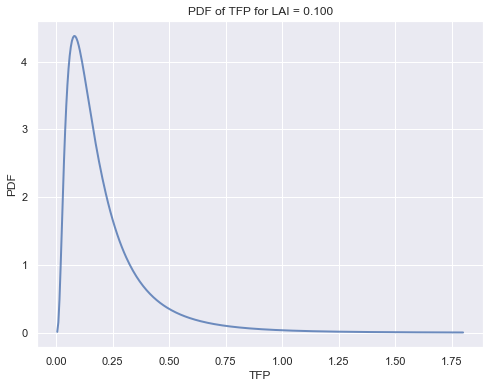

In [5]:
# Develop the probability distributions of TFP for each LAI value

mean_YP = 0.2 + vals_SM / 6   # mean_TFP is assumed to be equal to 0.2 + mean_LAI / 6
cov_YP = 0.2                  # cov_TFP is assumed to be the same for all levels
                              # Actual mean and COV values are to be found from literature
var_YP = mean_YP * cov_YP
incr_YP = 0.005
max_YP = 1.8                  # This is larger than 1 considering the variance

# Find the parameters to be used with the lognorm function 
mu_YP = np.log(mean_YP ** 2 / np.sqrt(var_YP + mean_YP ** 2))
sd_YP = np.sqrt(np.log(1 + var_YP / mean_YP ** 2) )

# Plot the PDF 
vals_YP = np.linspace(incr_YP, max_YP, num = 360)

p_YP = np.zeros([len(vals_SM), len(vals_YP)])
sumprob_YP = np.zeros(len(vals_SM))

for i in np.arange(len(vals_SM)):
    rv = lognorm(sd_YP[i], scale=np.exp(mu_YP[i]))
    pdf_YP = rv.pdf(vals_YP)
    p_YP[i, :] = pdf_YP * incr_YP   # YP probability
    sumprob_YP[i] = sum(p_YP[i, :])
    if i == 4:
        plt.figure(figsize = [8, 6])
        sns.lineplot(x=vals_YP, y=pdf_YP, lw=2, alpha=0.8, color='b')
        plt.xlabel('TFP')
        plt.ylabel('PDF')
        plt.title(f"PDF of TFP for LAI = %1.3f" % vals_SM[i])
    

## Loss Analysis

**DV**: Revenue loss / replacement value of the facility 

Revenue loss needs to be added to the mitigation cost for the final decision making.

DV decreases as TFP increases because more productivity means less loss.

Probability distribution of DV needs to be generated for each TFP value.


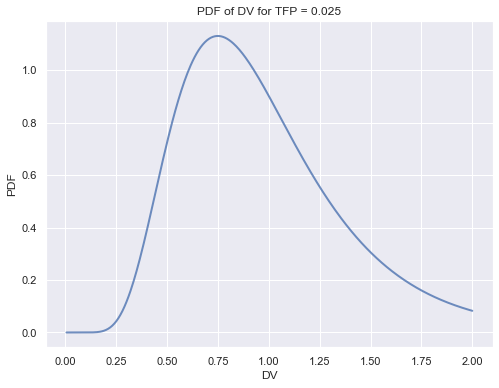

In [6]:
# Develop the probability distributions of DV for each TFP value

mean_DV = 1 - vals_YP / 2   # mean_DV is assumed to be equal to 1 - mean_TFP / 2
cov_DV = 0.2                # cov_DV is assumed to be the same for all levels
                            # Actual mean and COV values are to be found from literature
var_DV = mean_DV * cov_DV
incr_DV = 0.005
max_DV = 2                  # This is larger than 1 considering the variance

# Find the parameters to be used with the lognorm function 
mu_DV = np.log(mean_DV ** 2 / np.sqrt(var_DV + mean_DV ** 2))
sd_DV = np.sqrt(np.log(1 + var_DV / mean_DV ** 2) )

# Plot the PDF 
vals_DV = np.linspace(incr_DV, max_DV, num = 400)

p_DV = np.zeros([len(vals_YP), len(vals_DV)])
sumprob_DV = np.zeros(len(vals_YP))
POE_DV = np.zeros([len(vals_YP), len(vals_DV)])

for i in np.arange(len(vals_YP)):
    rv = lognorm(sd_DV[i], scale=np.exp(mu_DV[i]))
    pdf_DV = rv.pdf(vals_DV)
    p_DV[i, :] = pdf_DV * incr_DV   # DV probability
    sumprob_DV[i] = sum(p_DV[i, :])
    if i == 4:
        plt.figure(figsize = [8, 6])
        sns.lineplot(x=vals_DV, y=pdf_DV, lw=2, alpha=0.8, color='b')
        plt.xlabel('DV')
        plt.ylabel('PDF')
        plt.title(f"PDF of DV for TFP = %1.3f" % vals_YP[i])
    
    for j in np.arange(len(vals_DV)):
        if j == 0: 
            POE_DV[i, j] = sumprob_DV[i]
        else:
            POE_DV[i, j] = POE_DV[i, j-1] - p_DV[i,j]


In [7]:
POE_DV.shape

(360, 400)

## Loss Curve
Compute the loss curve with the total probability theorem

In [8]:
#  1st APPROACH

# POE = np.zeros(len(vals_DV))

# for n in np.arange(len(vals_DV)):
#     for k in np.arange(len(vals_YP)):
#         for i in np.arange(len(vals_SM)): 
#             for m in np.arange(len(p_IM)):
#                 POE[n] = POE[n] + POE_DV[k, n] * p_YP[i,k] * p_SM[m,i] * p_IM[m]

In [9]:
#  2nd APPROACH

import itertools

POE = np.zeros(len(vals_DV))

for n, k, i, m in itertools.product(np.arange(len(vals_DV)), np.arange(len(vals_YP)), np.arange(len(vals_SM)), np.arange(len(p_IM))):
    POE[n] = POE[n] + POE_DV[k, n] * p_YP[i,k] * p_SM[m,i] * p_IM[m]


In [10]:
POE

array([9.79288920e-01, 9.79229787e-01, 9.79133663e-01, 9.79004841e-01,
       9.78847004e-01, 9.78662880e-01, 9.78454365e-01, 9.78222698e-01,
       9.77968607e-01, 9.77692419e-01, 9.77394141e-01, 9.77073511e-01,
       9.76730050e-01, 9.76363080e-01, 9.75971757e-01, 9.75555077e-01,
       9.75111897e-01, 9.74640939e-01, 9.74140798e-01, 9.73609951e-01,
       9.73046762e-01, 9.72449489e-01, 9.71816287e-01, 9.71145218e-01,
       9.70434256e-01, 9.69681295e-01, 9.68884156e-01, 9.68040598e-01,
       9.67148325e-01, 9.66204997e-01, 9.65208240e-01, 9.64155655e-01,
       9.63044833e-01, 9.61873360e-01, 9.60638833e-01, 9.59338869e-01,
       9.57971116e-01, 9.56533263e-01, 9.55023054e-01, 9.53438292e-01,
       9.51776854e-01, 9.50036698e-01, 9.48215869e-01, 9.46312514e-01,
       9.44324880e-01, 9.42251328e-01, 9.40090336e-01, 9.37840503e-01,
       9.35500556e-01, 9.33069353e-01, 9.30545885e-01, 9.27929280e-01,
       9.25218803e-01, 9.22413860e-01, 9.19513996e-01, 9.16518895e-01,
      

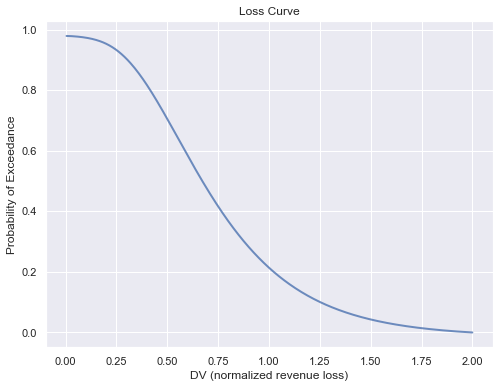

In [12]:
plt.figure(figsize = [8, 6])
sns.lineplot(x=vals_DV, y=POE, lw=2, alpha=0.8, color='b')
plt.xlabel('DV (normalized revenue loss)')
plt.ylabel('Probability of Exceedance')
plt.title("Loss Curve");

# Loss that corresponds to 0.5 POE is the median loss